In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import cv2 as cv
from pryngles import *
from pryngles import pixx
import time
extension="pixx"

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 15})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Import local functions
import extra_func as efunc

In [3]:
save_location = "/home/allard/Images/Report/Orbit2/"

orbit_i = 60 # 90 is edge-on, 0 is face-on #30
ring_i = 70 # 90 is edge-on, 0 is face-on #60
ring_l = 0
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=1, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=10000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.2, fe=2.25, i=gamma),
               optics=dict(nspangles=10000))

RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_0_4_0_8.dat")

lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,9)
print(lambs)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection()

    ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=False)
    ecl_fig.savefig(save_location + f"fig_at_{int((lamb-lamb_initial)*180/np.pi)}_ecl.png", dpi=500)
    obs_fig.savefig(save_location + f"fig_at_{int((lamb-lamb_initial)*180/np.pi)}_obs.png", dpi=500)
    star_fig.savefig(save_location + f"fig_at_{int((lamb-lamb_initial)*180/np.pi)}_star.png", dpi=500)
    plt.close()

[-1.57079633e+00 -7.85398167e-01 -3.20510352e-09  7.85398160e-01
  1.57079632e+00  2.35619449e+00  3.14159265e+00  3.92699081e+00
  4.71238898e+00]
True anomaly:  0.0
True anomaly:  45.0
True anomaly:  90.0
True anomaly:  135.0
True anomaly:  180.0
True anomaly:  225.0
True anomaly:  270.0
True anomaly:  315.0
True anomaly:  360.0


<IPython.core.display.Javascript object>


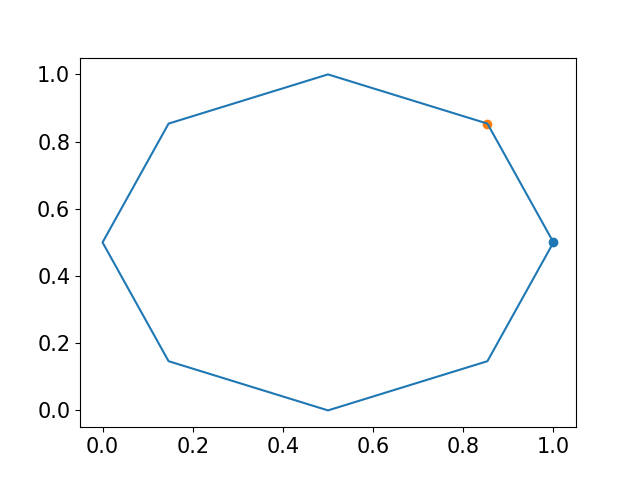

In [29]:
phi = np.linspace(0,2*np.pi,9)
a = 0.5
b = 0.5 #np.sin(np.pi/2-70*np.pi/180)
def loc_func(phi,a,b):
    x = a*np.cos(phi)+0.5
    y = b*np.sin(phi)+0.5
    return x,y

x,y = loc_func(phi,a,b)

fig = plt.figure()
plt.plot(x,y)
plt.scatter(x[0],y[0])
plt.scatter(x[1],y[1])
plt.show()



In [4]:
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

def draw_self_loop(ax,center, radius, facecolor='#2693de', edgecolor='#000000', theta1=-30, theta2=180):
    
    # Add the ring
    rwidth = 4
    ring = mpatches.Wedge(center, radius, theta1, theta2, width=rwidth)
    # Triangle edges
    offset = 20
    xcent  = center[0] - radius + (rwidth/2)
    left   = [xcent - offset, center[1]]
    right  = [xcent + offset, center[1]]
    bottom = [(left[0]+right[0])/2., center[1]+40]
#     leftarrow = plt.
    arrow  = plt.Polygon([left, right, bottom, left],color=facecolor,fill=True)
    p = PatchCollection(
        [ring, arrow], 
        edgecolor = edgecolor, 
        facecolor = facecolor
    )
    ax.add_collection(p)

2500


<IPython.core.display.Javascript object>


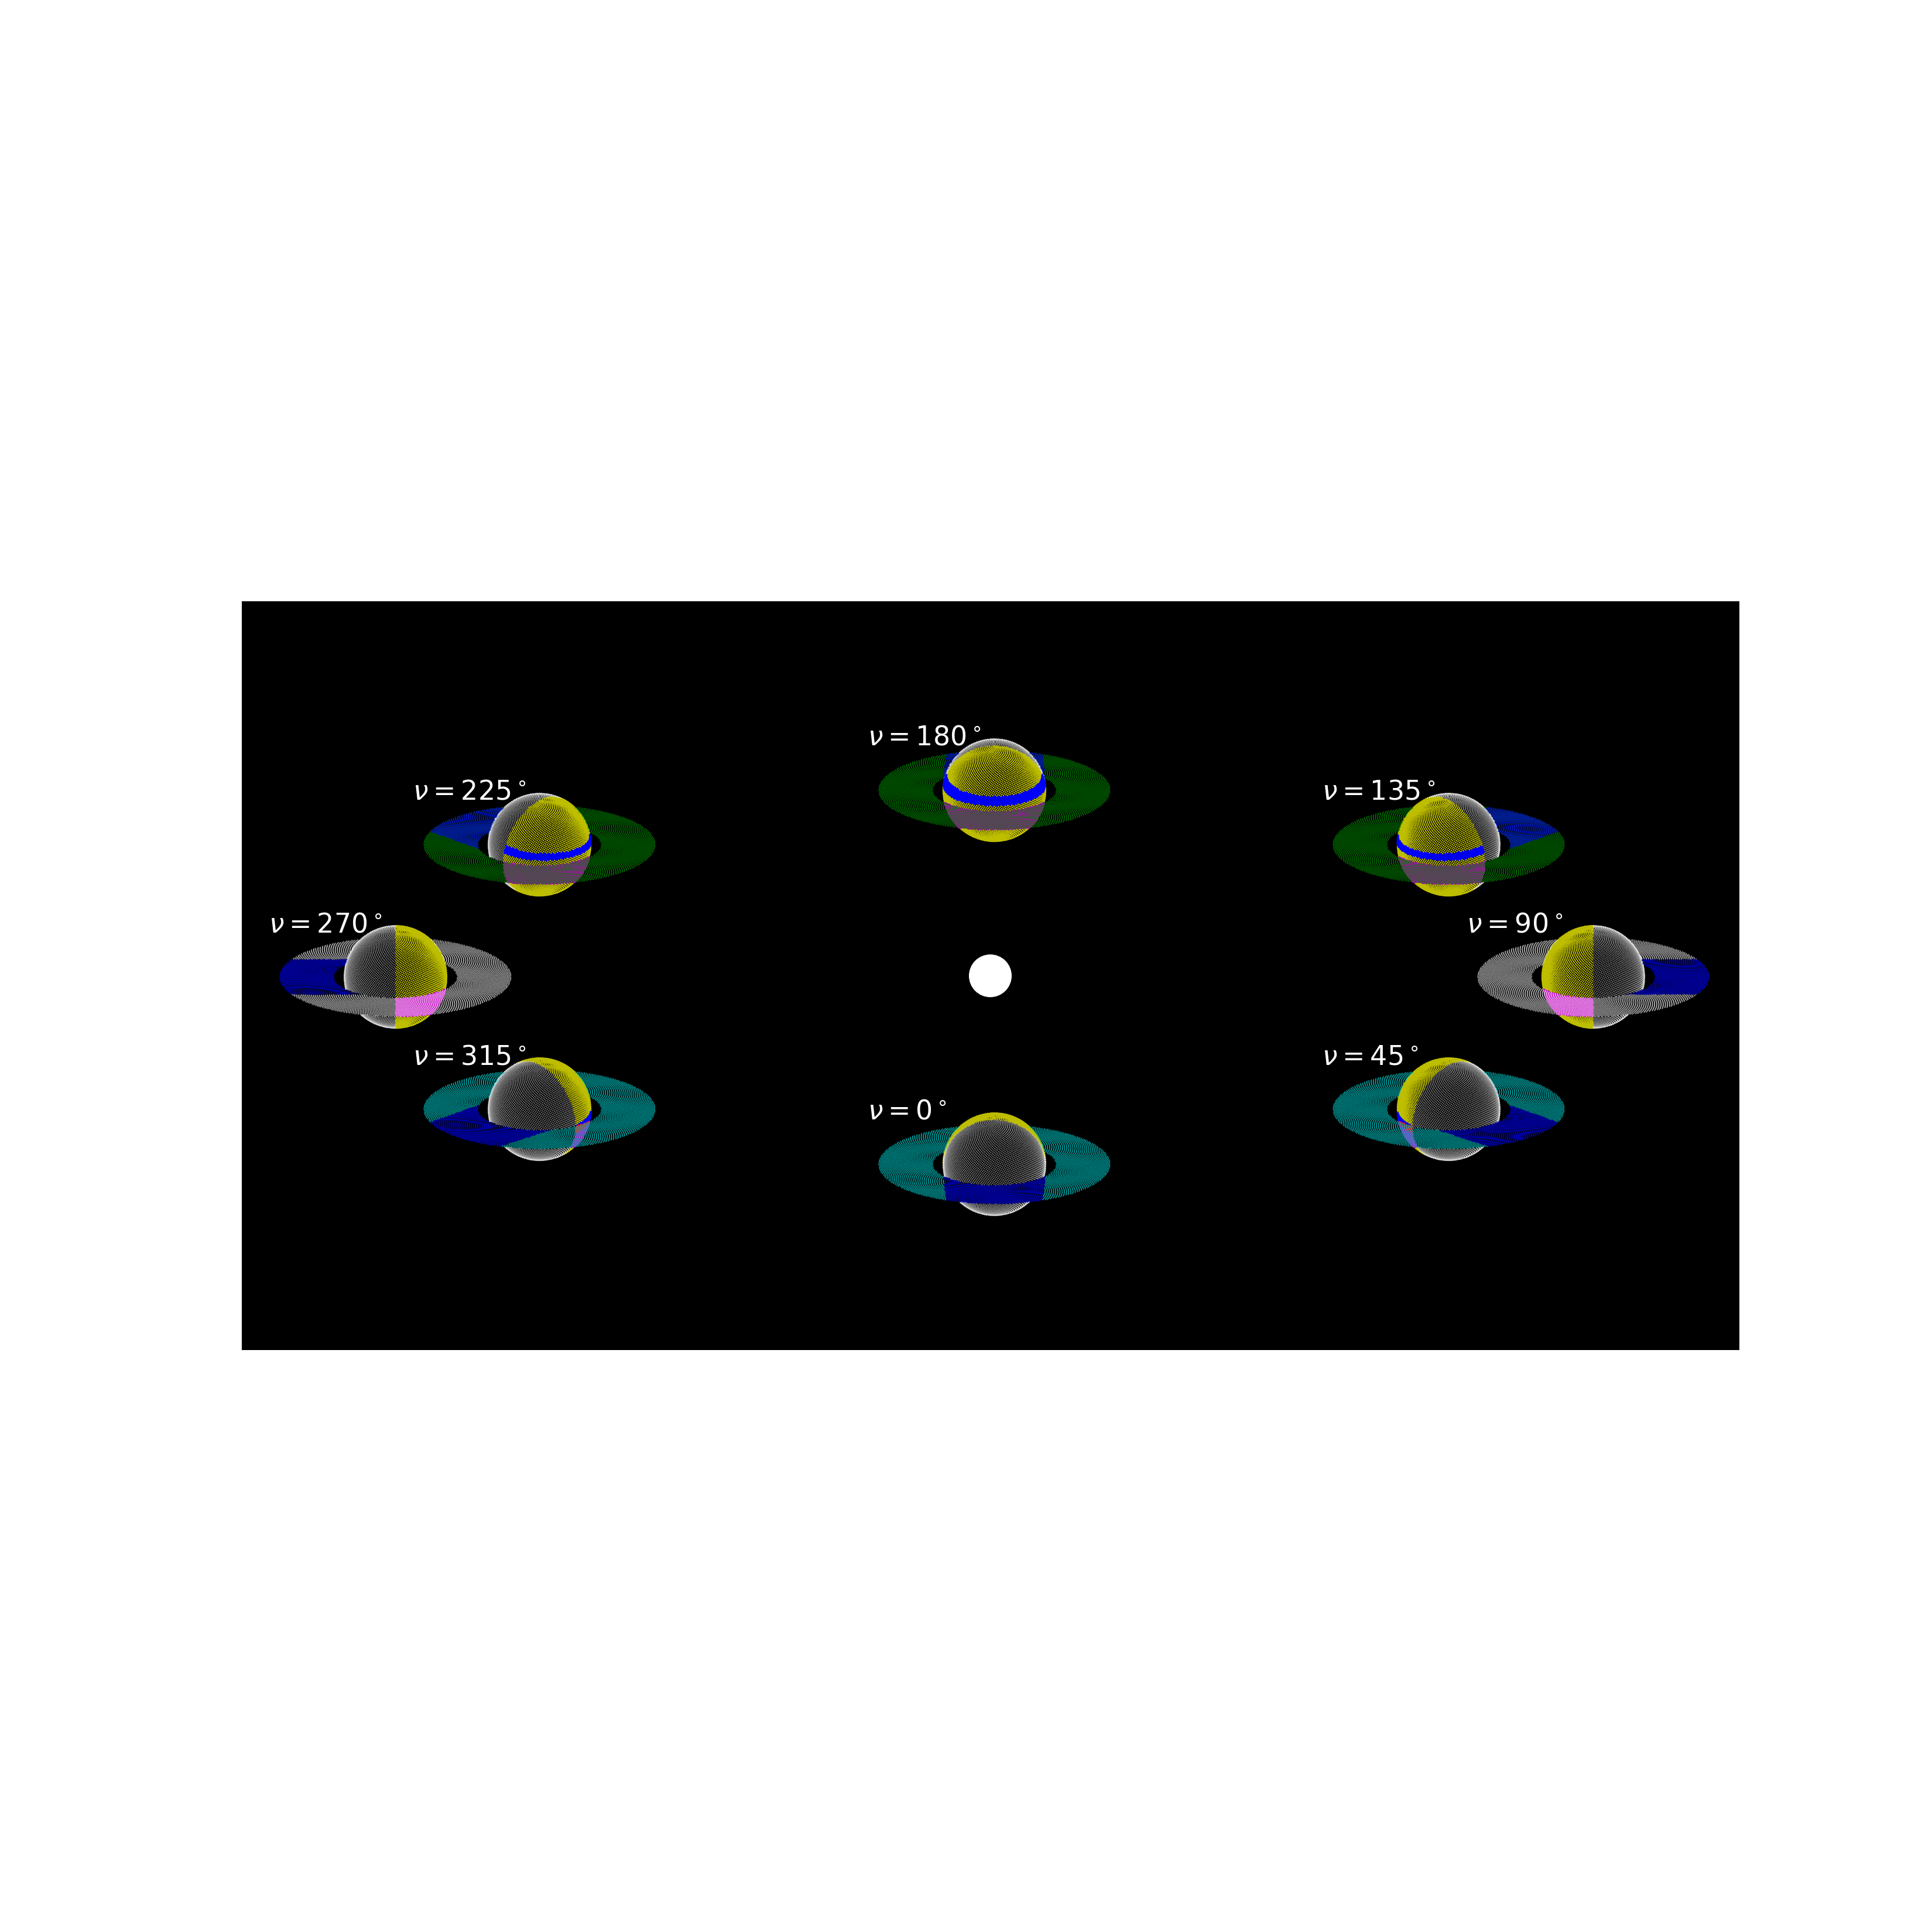

0 0
1 45
2 90
3 135
4 180
5 225
6 270
7 315


In [8]:
def loc_func(phi,a,b):
    x = a*np.cos(phi)+0.5
    y = b*np.sin(phi)+0.5
    return x,y

save_location = "/home/allard/Images/Report/Orbit2/"
lambs = np.array([0,45,90,135,180,225,270,315])

names = np.array(["$\nu=0 \degree$", "$\nu=45 \degree$", "$\nu=90 \degree$", "$\nu=135 \degree$",
                  "$\nu=180 \degree$", "$\nu=225 \degree$", "$\nu=270 \degree$", "$\nu=315 \degree$"])

ratio = np.sin(np.pi/2 - 60*np.pi/180)
xpixels = 5000
ypixels = int(xpixels*ratio)
print(ypixels)
img = np.zeros((ypixels,xpixels))

# Axis sizes
ysize = 0.4*ratio
xsize = 0.4
# Convert to 3 channel black (color)
img = cv.merge([img,img,img])

# Location of subplot
phi = np.linspace(-np.pi/2,3/2*np.pi,9)
a = 0.5
b = 0.5*ratio
xloc,yloc = loc_func(phi,a,b)

# Offset
eqv75 = 0.75#1-np.sin(45*np.pi/180)/2
eqv25 = 0.25#np.sin(45*np.pi/180)/2

xoffset = np.array([0.5*ysize,eqv75*ysize,ysize,eqv75*ysize,0.5*ysize,
                    eqv25*ysize,0,eqv25*ysize])
# xoffset = np.array([0.5*xsize,eqv75*xsize,xsize,eqv75*xsize,0.5*xsize,
#                     eqv25*xsize,0,eqv25*xsize])
yoffset = np.array([xsize,eqv25*xsize,0.5*xsize,eqv75*xsize,0,eqv75*xsize,
                    0.5*xsize,eqv25*xsize])
# yoffset = np.array([0,eqv25*xsize,0.5*xsize,eqv75*xsize,xsize,eqv75*xsize,
#                     0.5*xsize,eqv25*xsize])
# np.array([0,0.25*ysize,0.5*ysize,0.75*ysize,ysize,0.75*ysize,
#                     0.5*ysize,0.25*ysize])
sub_plot_locx = xloc[:-1]-xoffset
sub_plot_locy = yloc[:-1]-xsize*0.5#yoffset


fig = plt.figure(figsize=(33,33))
gs = fig.add_gridspec(1)
axs = gs.subplots(sharex=False)
axs.imshow(img)
star = plt.Circle((2500, 2500*(ratio)), 70, color='w')
axs.add_patch(star)

for ii,lamb in enumerate(lambs):
    print(ii,lamb)
    figure_loc = save_location + f"fig_at_{lamb}_obs.png"
    figure = cv.imread(figure_loc)

    subpos = [sub_plot_locx[ii],sub_plot_locy[ii],ysize,xsize]
    subax1 = efunc.add_subplot_axes(axs,subpos)

    b, g, r = cv.split(figure)
    tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
    _,alpha = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
    rgba = [r,g,b, alpha]
    figure_crop = cv.merge(rgba,4)
    scale = 6/9 #5/9
    width = int(figure_crop.shape[1] * scale)
    height = int(figure_crop.shape[0] * scale)
    dim = (width,height)
    resized = cv.resize(figure_crop, dim, interpolation = cv.INTER_AREA)
    subax1.imshow(resized, interpolation='spline36', aspect='auto')
    subax1.text(0.09, 0.67, f"$\\nu={lamb}^\circ$", 
                {'fontsize': 33}, horizontalalignment='left',
                verticalalignment='center', transform=subax1.transAxes,color="w")
    subax1.set_axis_off()
    
# style = "Simple, tail_width=2, head_width=4, head_length=8"
# kw = dict(arrowstyle=style, color="w")
# arrow = mpatches.FancyArrowPatch((200, 200), (120, 200),
#                              connectionstyle="arc3,rad=3.0", **kw)
# axs.add_patch(arrow)
# draw_self_loop(axs, (2500, 2500*(ratio)), 200, facecolor='white', edgecolor='white', theta1=180, theta2=70)
axs.set_axis_off()
fig.savefig("/home/allard/Results/Diff_positions_new.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/allard/Results/Diff_positions_new.eps", format='eps', bbox_inches='tight')
fig.savefig("/home/allard/Results/Diff_positions_new.svg", bbox_inches='tight', format='svg', dpi=600)
plt.show()


## Cover image

In [6]:
save_location = "/home/allard/Images/Report/"

orbit_i = 70 # 90 is edge-on, 0 is face-on #30
ring_i = 60 # 90 is edge-on, 0 is face-on #60
ring_l = 10
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=0.1, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=10000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.2, fe=3.0, i=gamma),
               optics=dict(nspangles=10000))

RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_1_0_0_8.dat")
RP.behavior["allow_non_uni"] = True

lamb_initial = lamb_star
lamb_final = lamb_initial + 180*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,3)
print(lambs)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

for lamb in lambs:
    RP.changeObserver([lamb_obs,beta_obs])
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection(taur=1.0)

    obs_fig = RP.plotRingedPlanetFlux(showstar=False,showfig=False,showtitle=False,
                                      axis=False,showcolorbar=False,
                                      cminmax=[1e-4,100])
    obs_fig.savefig(save_location + f"Cover_image_{int((lamb-lamb_initial)*180/np.pi)}_i60_obs.png", dpi=1200)
    plt.close()

[-2.05144389 -0.48064756  1.09014876]
True anomaly:  0.0
True anomaly:  90.0
True anomaly:  180.0


## Powerpoint images

In [5]:
save_location = "/home/allard/Images/Presentation/"

orbit_i = 75 # 90 is edge-on, 0 is face-on #30
ring_i = 40 # 90 is edge-on, 0 is face-on #60
ring_l = 50
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=1.0, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=10000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.2, fe=3.0, i=gamma),
               optics=dict(nspangles=10000))

RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_1_0_0_8.dat")
RP.behavior["allow_non_uni"] = True

lamb_initial = lamb_star
lamb_final = lamb_initial + 45*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,2)
print(lambs)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

for lamb in lambs:
    RP.changeObserver([lamb_obs,beta_obs])
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection(taur=1.0)

    obs_fig = RP.plotRingedPlanetFlux(showstar=False,showfig=False,showtitle=False,
                                      axis=True,showcolorbar=True,
                                      cminmax=[1e-4,100])
    obs_fig.savefig(save_location + 
            f"Presentation_image_{int((lamb-lamb_initial)*180/np.pi)}_i{ring_i}_oi{orbit_i}_rl{ring_l}_obs.png", dpi=1200)
    plt.close()

[-2.65657421 -1.87117605]
True anomaly:  0.0
True anomaly:  45.0


## Image of HIP

In [11]:
save_location = "/home/allard/Images/Presentation/"

# Parameters of fit taken from 2015 paper
i = -25  # 90 is edge-on, 0 is face-on
phi = 180 - 95

# Calculate ring orientation
ring_i,ring_l = efunc.normalConverter(i,phi)

ring_i*= 180/np.pi 
ring_l*= 180/np.pi
orbit_i = 89.97

gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=1.0, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=10000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.05, fe=2.6, i=gamma),
               optics=dict(nspangles=10000))

RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_1_0_0_8.dat")
RP.behavior["allow_non_uni"] = True

lamb_initial = lamb_star
lamb_final = lamb_initial + 90*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,2)
print(lambs)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

for lamb in lambs:
    RP.changeObserver([lamb_obs,beta_obs])
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection(taur=1.0)

    obs_fig = RP.plotRingedPlanetFlux(showstar=False,showfig=False,showtitle=False,
                                      axis=True,showcolorbar=False,
                                      cminmax=[1e-4,100])
    obs_fig.savefig(save_location + 
            f"Presentation_image_HIP_{int((lamb-lamb_initial)*180/np.pi)}_new.png", dpi=1200)
    plt.close()

Check ring orientation:  [1.4498902078941e-11, -8.495842918065932e-13, 6.700751065125132e-12]
[-1.1359306   0.43486573]
True anomaly:  0.0
True anomaly:  90.0


## New animation

In [9]:
save_location = "/home/allard/Images/Presentation/Animation/"

orbit_i = 70 # 90 is edge-on, 0 is face-on #30
ring_i = 60 # 90 is edge-on, 0 is face-on #60
ring_l = 10
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=0.6, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=10000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.2, fe=2.5, i=gamma),
               optics=dict(nspangles=10000))

RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_1_0_0_8.dat")
RP.behavior["allow_non_uni"] = True

lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,361)
# print(lambs)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

for ii,lamb in enumerate(lambs):
    RP.changeObserver([lamb_obs,beta_obs])
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection(taur=1.0)

    obs_fig = RP.plotRingedPlanetFlux(showstar=False,showfig=False,showtitle=False,
                                      axis=True,showcolorbar=True,
                                      cminmax=[1e-4,100])
    obs_fig.savefig(save_location + f"ani_fig_{ii}.png", dpi=300)
    plt.close()

True anomaly:  0.0
True anomaly:  0.9999999999999887
True anomaly:  2.0000000000000027
True anomaly:  3.000000000000004
True anomaly:  4.000000000000005
True anomaly:  4.999999999999995
True anomaly:  5.999999999999996
True anomaly:  6.999999999999997
True anomaly:  7.999999999999998
True anomaly:  9.0
True anomaly:  10.000000000000002
True anomaly:  11.000000000000002
True anomaly:  12.000000000000004
True anomaly:  13.000000000000005
True anomaly:  13.999999999999995
True anomaly:  14.999999999999995
True anomaly:  15.999999999999996
True anomaly:  16.999999999999996
True anomaly:  18.0
True anomaly:  19.0
True anomaly:  20.000000000000004
True anomaly:  21.000000000000004
True anomaly:  22.000000000000004
True anomaly:  22.999999999999993
True anomaly:  24.000000000000007
True anomaly:  24.999999999999996
True anomaly:  25.999999999999996
True anomaly:  27.0
True anomaly:  28.0
True anomaly:  29.000000000000004
True anomaly:  29.99999999999999
True anomaly:  31.000000000000004
True 

True anomaly:  357.0
True anomaly:  358.0
True anomaly:  359.0
True anomaly:  360.0
